# GEM ML Framework Demonstrator - Water Segmentation
In these notebooks, we will get a feeling of how the GEM ML framework can be used for the segmentation of water bodies using Sentinel-1 imagery as input and Sentinel-2 based normalized difference water index (NDWI) as a reference.
The idea is to use a neural network (NN) model for the analysis.
Thanks to the flexibility of the GEM ML framework, the model used can be replaced by changing the configuration only.
We will have a look at the following notebooks separately:
- 00_Configuration
- 01_DataAcquisition
- 02_DataNormalization
- 03_TrainingValidationTesting
- 04_PyTorchTasks_ModelForwardTask
- 05_PyTorchTasks_FeatureAttributionTasks (yet to come)
- 06_PyTorchTasks_UncertaintyQuantificationTasks (yet to come)
- 07_PyTorchTasks_DimensionalityReductionTasks (yet to come)

by Michael Engel (m.engel@tum.de)

-----------------------------------------------------------------------------------

# Data Normalization
Here, we want to normalize our data by common quantile scaling.
To do so, we will merge the T-Digests of each `EOPatch` from our training set.
Based on that, we will store the desired quantiles for data normalization.

In [1]:
import os
import sys
import platform
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import time
import natsort

import torch
import torch.multiprocessing as mp
from tensorboardX import SummaryWriter
from tensorboard import notebook

from sentinelhub import SHConfig, BBox, CRS, DataCollection, UtmZoneSplitter, DataCollection
from eolearn.core import FeatureType, EOPatch, MergeEOPatchesTask, MapFeatureTask, MergeFeatureTask, ZipFeatureTask, LoadTask, EONode, EOWorkflow, EOExecutor, OverwritePermission, SaveTask
from eolearn.io import SentinelHubDemTask, ExportToTiffTask, SentinelHubInputTask, SentinelHubEvalscriptTask, get_available_timestamps
from eolearn.mask import CloudMaskTask, JoinMasksTask

import rasterio
import geopandas as gpd
import pandas as pd
from shapely.geometry import Polygon,Point
import folium
from folium import plugins as foliumplugins

from libs.ConfigME import Config, importME
from libs.MergeTDigests import mergeTDigests
from libs.QuantileScaler_eolearn import QuantileScaler_eolearn_tdigest
from libs.Dataset_eolearn import Dataset_eolearn
from libs import AugmentME
from libs import ExecuteME

from tasks.TDigestTask import TDigestTask
from tasks.PickIdxTask import PickIdxTask
from tasks.SaveValidTask import SaveValidTask
from tasks.PyTorchTasks import ModelForwardTask

from utils.rasterio_reproject import rasterio_reproject
from utils.transforms import batchify, predict, mover, Torchify
from utils.parse_time_interval_observations import parse_time_interval_observations

print("Working Directory:",os.getcwd())
print("Environment:",os.environ['CONDA_DEFAULT_ENV'])
print("Executable:",sys.executable)

C:\Users\skryp\miniconda3\envs\eolearn_water\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Incorporating libs!
Incorporating tasks!
Incorporating utils!
Working Directory: D:\OneDrive\Offiziell\Promotion\Code\Git\eo-learn-examples\GEM-ML\Example_WaterSegmentation
Environment: eolearn_water
Executable: C:\Users\skryp\miniconda3\envs\eolearn_water\python.exe


# Config
First, we load our configuration file which provides all information we need throughout the script.

In [2]:
#%% load configuration file
config = Config.LOAD("config.dill")

# Merge T-Digests
Before we can do the normalization of our dataset, we need to access the distribution of the data.
The T-Digests can approximate cumulative distribution functions (CDF) without having the whole dataset in memory.
Accordingly, we can approximate the desired quantiles for normalization.

In [3]:
start = time.time()
tdigest = mergeTDigests(
    paths = [os.path.join(config["dir_train"],dir_) for dir_ in os.listdir(config["dir_train"])],
    feature = (FeatureType.SCALAR_TIMELESS, 'tdigest_data'),
    threads = 0 if platform.system()=="Windows" else config["threads"],
    checkthreads = True,
    bequiet = False
)
print(f"Merging of T-Digests took {time.time()-start:.2f}s using {config['threads']} thread(s)!")

125/125 calculations [100.00%] with 1 threads	
Merging of T-Digests took 35.00s using 1 thread(s)!


# Analyse T-Digests
Let's compute some quantiles for plotting the CDFs!

In [4]:
quantilesVV = np.array([tdigest[0].percentile(_) for _ in np.linspace(0,100,100)])
xVV = np.linspace(quantilesVV[0],quantilesVV[-1],100)
cdfVV = np.array([tdigest[0].cdf(_) for _ in quantilesVV])

quantilesVH = np.array([tdigest[1].percentile(_) for _ in np.linspace(0,100,100)])
xVH = np.linspace(quantilesVH[0],quantilesVH[-1],100)
cdfVH = np.array([tdigest[1].cdf(_) for _ in quantilesVH])

Let's have a look at the resulting CDFs!
For the sake of clarity, we will have a look at a 96%-interval, namely from the 2% to the 98% quantile.

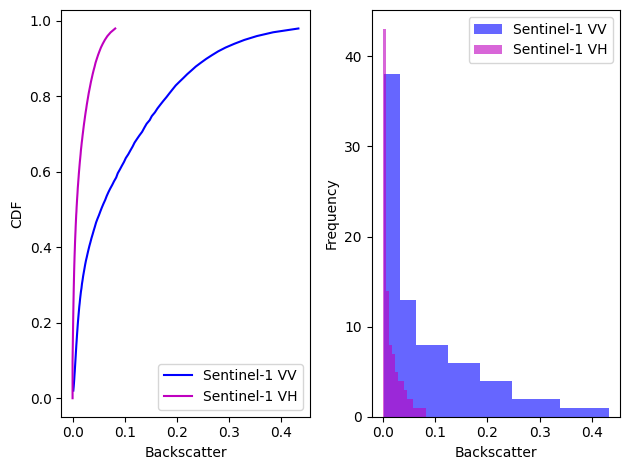

In [5]:
plt.figure()
plt.subplot(121)
plt.plot(quantilesVV[2:-2],cdfVV[2:-2],"b",label="Sentinel-1 VV")
plt.plot(quantilesVH[2:-2],cdfVH[2:-2],"m",label="Sentinel-1 VH")

plt.xlabel("Backscatter")
plt.ylabel("CDF")
plt.legend()

plt.subplot(122)
plt.hist(quantilesVV[2:-2],bins=int(np.sqrt(96)*1.5),fc="b",ec=None,alpha=0.6,label="Sentinel-1 VV")
plt.hist(quantilesVH[2:-2],bins=int(np.sqrt(96)*1.5),fc="m",ec=None,alpha=0.6,label="Sentinel-1 VH")
plt.xlabel("Backscatter")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()

We see that the input bands live in different ranges.
Hence, it is crucial for machine learning to normalize both.
For that purpose, we store the T-Digest to disk for later usage in our ML pipeline!

In [6]:
np.save(os.path.join(config["dir_results"],config["savename_tdigest"]),tdigest)

# Quantile Scaling
As discussed, we want to apply quantile scaling to our data.
We already merged the separate T-Digests to one and stored the result to disk.
Note that only the training samples have been used for that.

Since PyTorch asks for the shape `[batch_size x channels x timestamps x height x width]`, we need to reshape the data features accordingly.
Fortunately, the `QuantileScaler_eolearn_tdigest` can handle this by setting `transform=True`.
However, we do not need a temporal component - neither for the input data nor the reference.
Hence, we will use the class `Torchify` itself as provided from the `Dataset_eolearn` package which allows to squeeze the temporal dimension.

In [7]:
Scaler = QuantileScaler_eolearn_tdigest(
    tdigestarray = tdigest,
    minquantile = config["scaler_minquantile"],
    maxquantile = config["scaler_maxquantile"],
    nanval = config["scaler_nanval"],
    infval = config["scaler_infval"],
    valmin = config["scaler_valmin"],
    valmax = config["scaler_valmax"],
    transform = Torchify(1),
    savename = os.path.join(config["dir_results"],config["savename_scaler"])
)

Let's see whether it works!
First, we have to transform our quantiles.
Note that this transformation is a bit hacky as we do not have height nor width as we would for our `EOPatches`.

In [8]:
quantiles = np.stack((quantilesVV,quantilesVH),axis=-1)
quantiles_transformed = Scaler(quantiles).T

Let's visualise our numeric window in the distribution of our data!

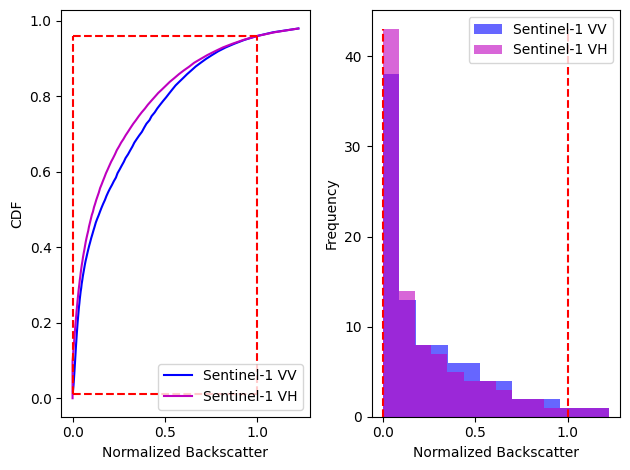

In [9]:
plt.figure()
plt.subplot(121)
plt.plot(quantiles_transformed[2:-2,0],cdfVV[2:-2],"b",label="Sentinel-1 VV")
plt.plot(quantiles_transformed[2:-2,1],cdfVH[2:-2],"m",label="Sentinel-1 VH")
plt.hlines([Scaler.minquantile,Scaler.maxquantile],Scaler.valmin,Scaler.valmax,colors='r',linestyles='--')
plt.vlines([Scaler.valmin,Scaler.valmax],Scaler.minquantile,Scaler.maxquantile,colors='r',linestyles='--')

plt.xlabel("Normalized Backscatter")
plt.ylabel("CDF")
plt.legend()

plt.subplot(122)
histVV = plt.hist(quantiles_transformed[2:-2,0],bins=int(np.sqrt(96)*1.5),fc="b",ec=None,alpha=0.6,label="Sentinel-1 VV")
histVH = plt.hist(quantiles_transformed[2:-2,1],bins=int(np.sqrt(96)*1.5),fc="m",ec=None,alpha=0.6,label="Sentinel-1 VH")
plt.vlines([Scaler.valmin,Scaler.valmax],0,np.max([histVV[0].max(),histVH[0].max()]),colors='r',linestyles='--')

plt.xlabel("Normalized Backscatter")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()

Down the river, we have to use our scaler again.
Hence, we store it to disk.

In [10]:
Scaler.save()

'D:\\OneDrive\\Offiziell\\Promotion\\Code\\Git\\eo-learn-examples\\GEM-ML\\Example_WaterSegmentation\\WaterSegmentationRun\\results\\WaterSegmentationRun_QuantileScaler.dill'